In [360]:
import os
import numpy as np
import pandas as pd

from scipy import stats
from scipy.ndimage import gaussian_filter
import statsmodels.api as sm

import pingouin

import matplotlib as mpl
import matplotlib.pyplot as plt  
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
import seaborn as sns

from datetime import date
import random

In [2]:
# no top and right spines in all plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [23]:
mother_path = 'D:/Multi-modal project/analysis/'
save_path = mother_path+'result/5. Unimodal object coding/'
fig_path = mother_path+'result/figures/'

### Parameter setting

In [4]:
sig_alpha = 0.01
sig_cohend = 0.4
cons_bin_crit = 5

gauss_sigma = 2
gauss_on = True

only_PER = True   # analyze only PER neurons?

condition = ['Multimodal','Visual','Auditory','Control']
cat = ['M','V','A','MV','MA','VA','MVA','None']

# colors for multimodal, vis-only, aud-only conditions
colorpalette = ['mediumorchid','cornflowerblue','lightcoral','gray']

today = str(date.today())

### Data preparation

In [5]:
cell_path = mother_path+'result/zFR export/13-Apr-2022 (5 trials)/'

data_path = mother_path+'result/3. Item-selectivity/2023-01-09/'
df = pd.read_csv(data_path+'2023-01-09_item-selectivity.csv')

# analyze only PER neurons
if only_PER == True:
    df = df[df['Region']=='PER']
    df.reset_index(inplace=True,drop=True)
df.insert(4,'Cat','')

for i in range(len(df)):
    cat_info = ''
    if df.loc[i,'M_sig'] == 1:
        cat_info += 'M'
    if df.loc[i,'V_sig'] == 1:
        cat_info += 'V'
    if df.loc[i,'A_sig'] == 1:
        cat_info += 'A'
    if cat_info=='':
        df.loc[i,'Cat'] = 'None'
    else:
        df.loc[i,'Cat'] = cat_info

In [7]:
# load selectivity data
Binary_M = pd.read_csv(data_path+'Binary_M.csv')
Binary_V = pd.read_csv(data_path+'Binary_V.csv')
Binary_A = pd.read_csv(data_path+'Binary_A.csv')
Binary_C = pd.read_csv(data_path+'Binary_C.csv')

Cohend_M = pd.read_csv(data_path+'Cohend_M.csv')
Cohend_V = pd.read_csv(data_path+'Cohend_V.csv')
Cohend_A = pd.read_csv(data_path+'Cohend_A.csv')
Cohend_C = pd.read_csv(data_path+'Cohend_C.csv')

# load surrogate correlation
surr_corr = pd.read_csv(mother_path+'result/4.1. Surrogate correlations/2023-03-29/surrogate_correlations.csv')

# load correlation
# pearson's r
corr = pd.read_csv(mother_path+'result/4. Selectivity correlations/2023-03-18/2023-03-18_selectivity_corr.csv')

# kendall's tau
#corr = pd.read_csv(mother_path+'result/4. Selectivity correlations/2023-03-28 (kendall)/2023-03-28_selectivity_corr.csv')

corr = corr[corr.Region=='PER']
corr.reset_index(inplace=True,drop=True)

# add selectivity correlation data to the data frame
df['MV_corr'] = corr['MV corr']
df['MA_corr'] = corr['MA corr']
df['VA_corr'] = corr['VA corr']

In [8]:
# empty list for result csv file
result=[]

### M-V, M-A correlation histogram

In [54]:
corr_crit = [np.percentile(surr_corr['M-V corr'],95),
             np.percentile(surr_corr['M-A corr'],95),
             np.percentile(surr_corr['V-A corr'],95)]

V = df[(df.Cat=='MV')|(df.Cat=='MVA')]
V.reset_index(inplace=True,drop=True)
MV_sig_count = sum(V['MV_corr']>corr_crit[0])

A = df[(df.Cat=='MA')|(df.Cat=='MVA')]
A.reset_index(inplace=True,drop=True)
MA_sig_count = sum(A['MA_corr']>corr_crit[1])

print('% of cells having sig M-V correlation:', f'{MV_sig_count/len(V)*100:.2f}','%')
print('% of cells having sig M-A correlation:', f'{MA_sig_count/len(A)*100:.2f}','%')

% of cells having sig M-V correlation: 31.94 %
% of cells having sig M-A correlation: 44.21 %


In [63]:
prop = np.array([[len(V)-MV_sig_count,MV_sig_count],[len(A)-MA_sig_count,MA_sig_count]])
stat, p, dof, expected = stats.chi2_contingency(prop)

print('%%% Chi-square results %%%')
print(f"Test statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")

%%% Chi-square results %%%
Test statistic: 2.1019
P-value: 0.1471
Degrees of freedom: 1


In [374]:
z1,p1 = sm.stats.proportions_ztest(count = prop[0,0],nobs = prop[0,:].sum(),
                                 value = 0.5,alternative = 'two-sided')
z2,p2 = sm.stats.proportions_ztest(count = prop[1,0],nobs = prop[1,:].sum(),
                                 value = 0.5,alternative = 'two-sided')

print('**** Proportion z-test with 50% ****')
print('For visual')
print(f'zstat: {z1:.3f}')
print(f'pvalue: {p1:.3f}')
print('===================')
print('For auditory')
print(f'zstat: {z2:.3f}')
print(f'pvalue: {p2:.3f}')
print('===================')

**** Proportion z-test with 50% ****
For visual
zstat: 3.286
pvalue: 0.001
For auditory
zstat: 1.136
pvalue: 0.256


### MV_sig_count

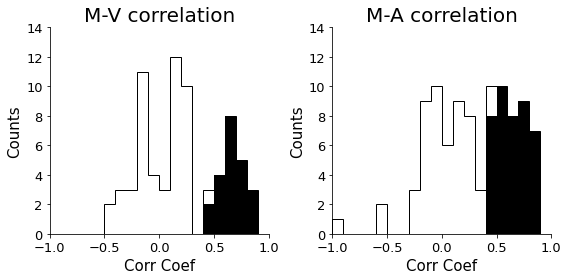

In [53]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

x = [V['MV_corr'],A['MA_corr']]
t = ['M-V correlation','M-A correlation']
x2 = [V.loc[V['MV_corr']>corr_crit[0],'MV_corr'],A.loc[A['MA_corr']>corr_crit[1],'MA_corr']]

for i in range(2):
    ax[i].hist(x[i],color='black',fill=False,
               bins=np.arange(-1,1,0.1),histtype='step')
    ax[i].hist(x2[i],color='black',
               bins=np.arange(-1,1,0.1),histtype='stepfilled')
    ax[i].set_title(t[i],fontsize=20)
    ax[i].set_ylabel('Counts',fontsize=15)
    ax[i].set_ylim([0,14])
    ax[i].set_yticks(range(0,16,2))
    ax[i].set_xlabel('Corr Coef',fontsize=15)
    ax[i].set_xlim([-1,1])
    ax[i].tick_params(axis='both',which='major',labelsize=13)

fig.tight_layout()
plt.savefig(fig_path+'unimodal_corr_hist.svg')
plt.savefig(fig_path+'unimodal_corr_hist.png',dpi=200,facecolor='white')

### Comparing selectivity between modalities
1. Selectivity duration
2. Sum of Cohen's d (within significant selectivity)
3. Selectivity peak

### Visualizing temporal overlap (non-overlap) of object-selectivity

In [33]:
def check_continuous(binary):
    nonzeros = np.nonzero(binary)[0]
    if len(nonzeros) == 0:
        return np.zeros((1, 1))
    diffs = np.diff(nonzeros)
    boundaries = np.concatenate(([0], np.where(diffs != 1)[0] + 1, [len(nonzeros)]))
    result = np.zeros((len(boundaries) - 1, 2))
    for i in range(len(result)):
        result[i, 0] = nonzeros[boundaries[i]]
        result[i, 1] = nonzeros[boundaries[i+1]-1]
    return result

In [48]:
def plot_overlap(ax,mod,color):
    if mod == 'visual':
        df = V
        df_sort = V_sorted
        binary = Binary_V
        t = 'M-V overlap'
    else:
        df = A
        df_sort = A_sorted
        binary = Binary_A        
        t = 'M-A overlap'
        
    for cell_order,i in enumerate(df_sort):
        key = df.loc[i,'Key']
        M = Binary_M[Binary_M.iloc[:,0]==key].iloc[:,1:].values[0]
        nM = binary[binary.iloc[:,0]==key].iloc[:,1:].values[0]
        
        M_cont = check_continuous(M)
        nM_cont = check_continuous(nM)
        
        overlap = np.zeros((95,))
        for j in range(95):
            if (M[j]==nM[j])*(M[j]!=0):
                overlap[j] = 1
        overlap_cont = check_continuous(overlap)
        
        for j in range(M_cont.shape[0]):
            ax.hlines(cell_order+1,M_cont[j,0],M_cont[j,1],colors='purple',linewidth=6,alpha=0.5)
        for j in range(nM_cont.shape[0]):
            ax.hlines(cell_order+1,nM_cont[j,0],nM_cont[j,1],colors=color,linewidth=6,alpha=0.5)
            
        if overlap_cont.sum()!=0:
            for j in range(overlap_cont.shape[0]):
                rec = Rectangle((overlap_cont[j,0],cell_order+0.5),
                                overlap_cont[j,1]-overlap_cont[j,0],1,
                                fill=False,color='black',linewidth=3)
                ax.add_patch(rec)
    
    ax.set_xlim([0,95])
    ax.set_ylabel('Cell ID')
    ax.set_ylim([0,len(df_sort)])    
    ax.set_yticks([1,10,20,30,40,len(df_sort)])
    ax.set_xlabel('Time (ms)')
    ax.set_xticks([0,40,95])
    ax.set_xticklabels([0,400,950])    
    ax.set_title(t,fontsize=20)

In [35]:
V = df[(df.Cat=='MV')|(df.Cat=='MVA')]
V.reset_index(inplace=True,drop=True)

A = df[(df.Cat=='MA')|(df.Cat=='MVA')]
A.reset_index(inplace=True,drop=True)

V = V[V['MV_corr']<corr_crit[0]]
V.reset_index(inplace=True,drop=True)

A = A[A['MA_corr']<corr_crit[1]]
A.reset_index(inplace=True,drop=True)

# sort cells based on peak selectivity time in multimodal condition
V_sorted = sorted(range(len(V.Key)),key=lambda k:V.loc[k,'M_peaktime'])
A_sorted = sorted(range(len(A.Key)),key=lambda k:A.loc[k,'M_peaktime'])

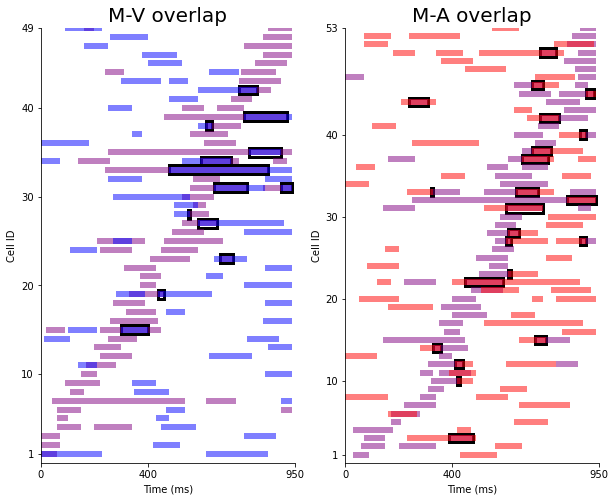

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,8))
plot_overlap(ax[0],'visual','blue')
plot_overlap(ax[1],'auditory','red')

plt.savefig(fig_path+'unimodal_overlap.svg')
plt.savefig(fig_path+'unimodal_overlap.png',dpi=200,facecolor='white')

### Temporal spanning of selectivity signals
to show that temporally heterogeneous object-selective signals spanned equally across all task epoch.

In [109]:
V = df[(df.Cat=='MV')|(df.Cat=='MVA')]
V.reset_index(inplace=True,drop=True)

A = df[(df.Cat=='MA')|(df.Cat=='MVA')]
A.reset_index(inplace=True,drop=True)

V = V[V['MV_corr']<corr_crit[0]]
V.reset_index(inplace=True,drop=True)

A = A[A['MA_corr']<corr_crit[1]]
A.reset_index(inplace=True,drop=True)

In [110]:
result_MinV = np.empty((0,95))
result_VinV = np.empty((0,95))

for v in V.Key:
    MinV = np.abs(Binary_M[Binary_M.iloc[:,0]==v].iloc[:,1:96].values[0])
    VinV = np.abs(Binary_V[Binary_V.iloc[:,0]==v].iloc[:,1:96].values[0])
    
    result_MinV = np.append(result_MinV,[MinV],axis=0)
    result_VinV = np.append(result_VinV,[VinV],axis=0)
    
    
result_MinA = np.empty((0,95))
result_AinA = np.empty((0,95))

for a in A.Key:
    MinA = np.abs(Binary_M[Binary_M.iloc[:,0]==a].iloc[:,1:96].values[0])
    AinA = np.abs(Binary_A[Binary_A.iloc[:,0]==a].iloc[:,1:96].values[0])
    
    result_MinA = np.append(result_MinA,[MinA],axis=0)
    result_AinA = np.append(result_AinA,[AinA],axis=0)

In [181]:
# smoothing
bin_size = 5
num_bin = int(95/bin_size)

result_smooth = np.zeros((4,num_bin))

for i in range(num_bin):    
    result_smooth[0,i] = np.sum(np.any(result_MinV[:,i*bin_size:(i+1)*bin_size]==1,axis=1))
    result_smooth[1,i] = np.sum(np.any(result_VinV[:,i*bin_size:(i+1)*bin_size]==1,axis=1))
    result_smooth[2,i] = np.sum(np.any(result_MinA[:,i*bin_size:(i+1)*bin_size]==1,axis=1))
    result_smooth[3,i] = np.sum(np.any(result_AinA[:,i*bin_size:(i+1)*bin_size]==1,axis=1))

result_smooth[0:2,:] = result_smooth[0:2,:]/len(V)
result_smooth[2:4,:] = result_smooth[2:4,:]/len(A)

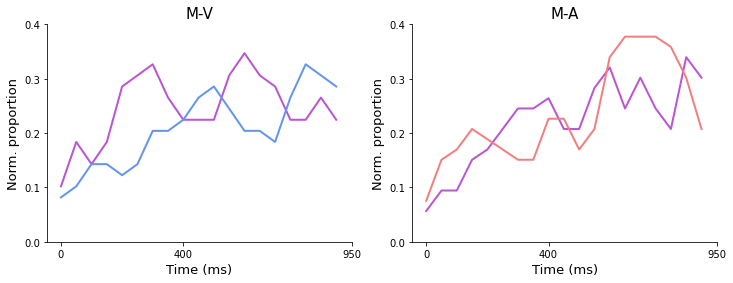

In [183]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

t = ['M-V','M-A']
for i in range(2):
    ax[i].plot(result_smooth[2*i,:],color=colorpalette[0],linewidth=2)
    ax[i].plot(result_smooth[2*i+1,:],color=colorpalette[i+1],linewidth=2)
    ax[i].set_ylim([0,0.4])
    ax[i].set_yticks([0,0.1,0.2,0.3,0.4])
    ax[i].set_xticks([0,40/bin_size,95/bin_size])
    ax[i].set_xticklabels([0,400,950]);
    ax[i].set_title(t[i],fontsize=15)
    ax[i].set_ylabel('Norm. proportion',fontsize=13)
    ax[i].set_xlabel('Time (ms)',fontsize=13)

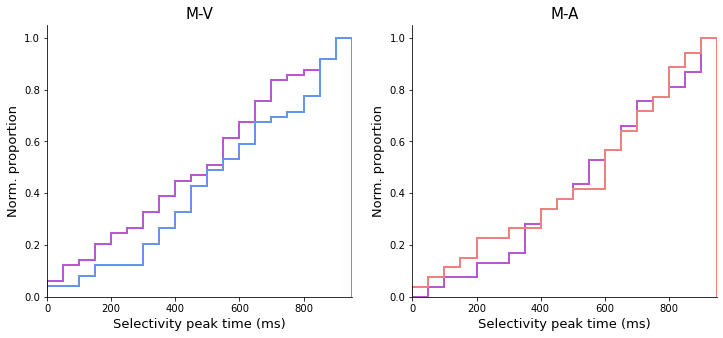

In [218]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

hist_result = [V.M_peaktime,V.V_peaktime,A.M_peaktime,A.A_peaktime]

t = ['M-V','M-A']
for i in range(2):
    ax[i].hist(hist_result[2*i],color=colorpalette[0],bins=range(0,1000,50),
               cumulative=True,density=True,histtype='step',linewidth=2)
    ax[i].hist(hist_result[2*i+1],color=colorpalette[i+1],bins=range(0,1000,50),
               cumulative=True,density=True,histtype='step',linewidth=2)
    ax[i].set_xlim([0,950])
    ax[i].set_title(t[i],fontsize=15)
    ax[i].set_ylabel('Norm. proportion',fontsize=13)
    ax[i].set_xlabel('Selectivity peak time (ms)',fontsize=13)

In [235]:
for i in range(4):
    s,p = stats.kstest(hist_result[i], stats.uniform(loc=0, scale=950).cdf)
    print(f"KS statistic: {s}")
    print(f"P-value: {p}")
    print('==================================')

KS statistic: 0.0897959183673469
P-value: 0.7912294658557493
KS statistic: 0.2038668098818475
P-value: 0.029105262374789498
KS statistic: 0.21132075471698114
P-value: 0.014834988512267278
KS statistic: 0.2164846077457795
P-value: 0.011650246884429949


### Temporal cross-correlation of object-selectivity

In [339]:
V_max_corr = np.array([])
for v in V.Key:
    M_cohen = np.abs(Cohend_M[Cohend_M.iloc[:,0]==v].iloc[:,1:96].values[0])
    M_binary = Binary_M[Binary_M.iloc[:,0]==v].iloc[:,1:96].values[0]
    
    V_cohen = np.abs(Cohend_V[Cohend_V.iloc[:,0]==v].iloc[:,1:96].values[0])
    V_binary = Binary_V[Binary_V.iloc[:,0]==v].iloc[:,1:96].values[0]

    M_cohen[M_binary==0] = 0    
    V_cohen[V_binary==0] = 0

    crosscorr = np.correlate(M_cohen,V_cohen,mode='full')    
    V_max_corr = np.append(V_max_corr,np.argmax(crosscorr))
    
A_max_corr = np.array([])
for a in A.Key:
    M_cohen = np.abs(Cohend_M[Cohend_M.iloc[:,0]==a].iloc[:,1:96].values[0])
    M_binary = Binary_M[Binary_M.iloc[:,0]==a].iloc[:,1:96].values[0]
    
    A_cohen = np.abs(Cohend_A[Cohend_A.iloc[:,0]==a].iloc[:,1:96].values[0])
    A_binary = Binary_A[Binary_A.iloc[:,0]==a].iloc[:,1:96].values[0]

    M_cohen[M_binary==0] = 0    
    A_cohen[A_binary==0] = 0

    crosscorr = np.correlate(M_cohen,A_cohen,mode='full')    
    A_max_corr = np.append(A_max_corr,np.argmax(crosscorr))

In [349]:
len(crosscorr)

189

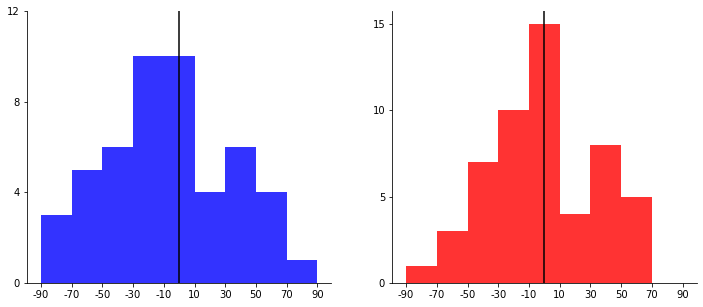

In [381]:
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].hist(V_max_corr,bins=range(4,200,20),color='blue',alpha=0.8)
ax[0].axvline(x=94,color='black')
ax[0].set_xticks(range(4,185,20));
ax[0].set_xticklabels(range(-90,91,20));
ax[0].set_yticks(range(0,14,4))

ax[1].hist(A_max_corr,bins=range(4,200,20),color='red',alpha=0.8)
ax[1].axvline(x=94,color='black')
ax[1].set_xticks(range(4,185,20));
ax[1].set_xticklabels(range(-90,91,20));
ax[1].set_yticks(range(0,20,5))

plt.savefig(fig_path+'unimodal_crosscorr.svg')

In [395]:
prop = [sum(V_max_corr<94),sum(V_max_corr>94)]
prop2 = [sum(A_max_corr<94),sum(A_max_corr>94)]

print(f'V>M: {prop[0]/len(V_max_corr)*100:.2f}% ({prop[0]}) / V<M: {prop[1]/len(V_max_corr)*100:.2f}% ({prop[1]})')
print(f'A>M: {prop2[0]/len(A_max_corr)*100:.2f}% ({prop2[0]}) / A<M: {prop2[1]/len(A_max_corr)*100:.2f}% ({prop2[1]})')

V>M: 55.10% (27) / V<M: 44.90% (22)
A>M: 58.49% (31) / A<M: 41.51% (22)


In [376]:
z1,p1 = sm.stats.proportions_ztest(count = sum(V_max_corr<94),nobs = len(V_max_corr),
                                 value = 0.5,alternative = 'two-sided')
z2,p2 = sm.stats.proportions_ztest(count = sum(A_max_corr<94),nobs = len(A_max_corr),
                                 value = 0.5,alternative = 'two-sided')

print('**** Proportion z-test with 50% ****')
print('For visual')
print(f'zstat: {z1}')
print(f'pvalue: {p1}')
print('==========================')
print('For auditory')
print(f'zstat: {z2}')
print(f'pvalue: {p2}')
print('==========================')

**** Proportion z-test with 50% ****
For visual
zstat: 0.7180336973794401
pvalue: 0.4727365096493438
For auditory
zstat: 1.254464169239663
pvalue: 0.20967334139176408
